Name: Smita Gupta<br>
USC ID: 4123927261

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
import sys
import copy
import string
import os
from sklearn.preprocessing import MinMaxScaler
import operator
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2nd) (Deep) CNNs for Image Colorization<br><br>
(a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image.
we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.
<br><br>
(b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [5]:
cifar10 = keras.datasets.cifar10
(X_train_all, y_train_all), (X_test, y_test) = cifar10.load_data()

In [6]:
print("Before Extraction:")
print("Training Set: ", X_train_all.shape, y_train_all.shape)
print("Testing Set: ", X_test.shape, y_test.shape)

X_train_reshape = X_train_all.reshape(-1, 32*32*3)
y_train_reshape = y_train_all.reshape(-1)

X_test_reshape = X_test.reshape(-1, 32*32*3)
y_test_reshape = y_test.reshape(-1)

X_train = X_train_reshape[y_train_reshape == 2].reshape(-1, 32, 32, 3)
y_train = y_train_reshape[y_train_reshape == 2]

X_test = X_test_reshape[y_test_reshape == 2].reshape(-1, 32, 32, 3)
y_test = y_test_reshape[y_test_reshape == 2]

print("\nAfter Extraction:")
print("Training Set: ", X_train.shape, y_train.shape)
print("Testing Set: ", X_test.shape, y_test.shape)

Before Extraction:
Training Set:  (50000, 32, 32, 3) (50000, 1)
Testing Set:  (10000, 32, 32, 3) (10000, 1)

After Extraction:
Training Set:  (5000, 32, 32, 3) (5000,)
Testing Set:  (1000, 32, 32, 3) (1000,)


2) c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

Concatenated Data Set:
  (6000, 32, 32, 3) (6000,)

Original Picture is:


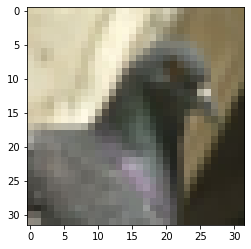

In [7]:
X_data = np.concatenate((X_train,X_test))
y_data = np.full((6000,), 2)

print("Concatenated Data Set:\n ", X_data.shape, y_data.shape)
print("\nOriginal Picture is:")
plt.imshow(X_data[666])

2) d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters
will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance.
These are the outputs of your network, whose each pixel falls in one of those k classes.

In [8]:
# Since the Kmeans classifier expected X_train's shape <= 2, so we have to reshape it again.
X_data_reshape = X_data.reshape(-1, 3)
k_means_clf = KMeans(n_clusters=4, random_state=2333, n_init=10).fit(X_data_reshape)
main_colors = k_means_clf.cluster_centers_
y_predict = k_means_clf.labels_

Converted Picture is:


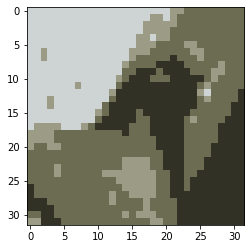

In [9]:
X_converted = np.array(
        [main_colors[y_predict[i]] for i in range(len(X_data_reshape))], dtype=np.uint8
).reshape(-1, 32, 32, 3)

print("Converted Picture is:")
plt.imshow(X_converted[666])

Suggested Picture is:


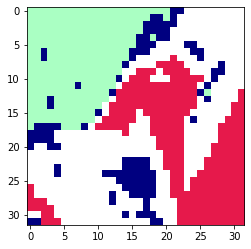

In [10]:
suggest_color = np.array([
    [0,0,128],
    [230,25,75],
    [170,255,195],
    [255,255,255]
], dtype=np.uint8)

X_suggest = np.array(
        [suggest_color[y_predict[i]] for i in range(len(X_data_reshape))], dtype=np.uint8
).reshape(-1, 32, 32, 3)

print("Suggested Picture is:")
plt.imshow(X_suggest[666])

2) e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

Grayscale Picture is:


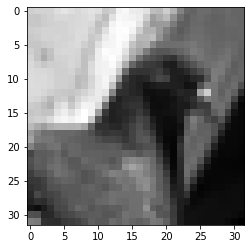

In [11]:
X_gray = np.array([rgb2gray(X_data[i]) for i in range(len(X_data))])
print("Grayscale Picture is:")
plt.imshow(X_gray[666], cmap=plt.cm.gray)

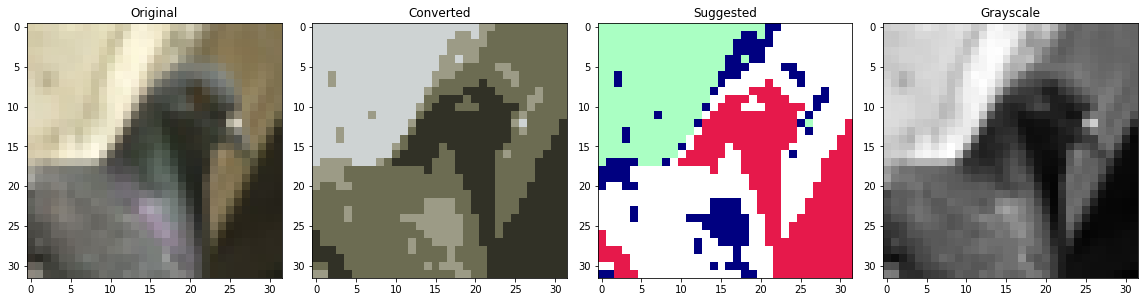

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(X_data[666])
ax[0].set_title("Original")
ax[1].imshow(X_converted[666])
ax[1].set_title("Converted")
ax[2].imshow(X_suggest[666])
ax[2].set_title("Suggested")
ax[3].imshow(X_gray[666], cmap=plt.cm.gray)
ax[3].set_title("Grayscale")

fig.tight_layout()
plt.show()

2) (f) Set up a deep convolutional neural network with two convolution layers (or more)
and two (or more) MLP layers. Use 5 × 5 filters and a softmax output layer.
Determine the number of filters, strides, and whether or not to use padding your-
self. Use a minimum of one max pooling layer. Use a classification scheme, which
means your output must determine one of the k = 4 color classes for each pixel in
your grayscale image. Your input is a grayscale version of an image (32 × 32 × 1)
and the output is 32×32×4. The output assigns one of the k = 4 colors to
each of the 32 × 32 pixels; therefore, each of the pixels is classified into one of the
classes [1 0 0 0],[0 1 0 0],[0 0 1 0],[0 0 0 1]. After each pixel is classified into one
of the main colors, the RGB code of that color can be assigned to the pixel. For
example, if the third main color7 is [255 255 255] and pixel (32,32) of an image
has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the
(32,32) place in the output can be associated with [255 255 255]. The size of the
output of the convolutional part, c1 × c2 depends on the size of the convolutional
layers you choose and is a feature map, which is a matrix. That matrix must be
flattened or reshaped, i.e. must be turned into a vector of size c1c2 ×1, before it is
fed to the MLP part. Choose the number of neurons in the first layer of the MLP
(and any other hidden layers, if you are willing to have more than one hidden
layer) yourself, but the last layer must have 32 × 32 × 4 = 4096 neurons, each of
which represents a pixel being in one of the k = 4 classes. Add a softmax layer which will choose the highest value out of its k = 4 inputs for each of the 1024
pixels; therefore, the output of the MLP has to be reshaped into a 32 × 32 × 4
matrix, and to get the colored image, the RGB vector of each of the k = 4 classes
has to be converted to the RGB vector, so an output image will be 32 × 32 × 3.
Train at least for 5 epochs (30 epochs is strongly recommended). Plot training,
(validation), and test errors in each epoch. Report the train and test errors and
visually compare the artificially colored versions of the first 10 images in the test set with the original images.

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore')
y_sample = [[0], [1], [2], [3]]
encoder.fit(y_sample)
y_encoded = encoder.transform(y_predict.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 4)
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    X_gray.reshape(-1, 32, 32, 1), y_encoded, test_size=0.1, random_state=666)

In [14]:
X_train_gray.shape, y_train_gray.shape, X_test_gray.shape, y_test_gray.shape

((5400, 32, 32, 1), (5400, 32, 32, 4), (600, 32, 32, 1), (600, 32, 32, 4))

In [15]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), 
                        padding='same', input_shape=(32,32,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), 
                        padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Dense(32, activation="softmax"),
    keras.layers.Dense(4, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(optimizer=keras.optimizers.SGD(0.001), 
              loss='categorical_crossentropy', metrics=["accuracy"])

In [17]:
epochs = 30
output_dir = "./cnn_checkpoint"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
checkpoint_prefix = os.path.join(output_dir, 'ck_{epoch:02d}.hdf5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix,
    save_weights_only= True
)
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

history = model.fit(X_train_gray, y_train_gray, epochs=epochs, 
                    validation_data=(X_test_gray, y_test_gray), 
                    callbacks=[checkpoint_callback, earlyStoppingCk])

Epoch 1/30
169/169 [==============================] - 77s 455ms/step - loss: 1.3782 - accuracy: 0.2962 - val_loss: 1.3775 - val_accuracy: 0.2902
Epoch 2/30
169/169 [==============================] - 82s 483ms/step - loss: 1.3754 - accuracy: 0.2962 - val_loss: 1.3750 - val_accuracy: 0.2902
Epoch 3/30
169/169 [==============================] - 65s 386ms/step - loss: 1.3728 - accuracy: 0.2962 - val_loss: 1.3726 - val_accuracy: 0.2902
Epoch 4/30
169/169 [==============================] - 65s 386ms/step - loss: 1.3705 - accuracy: 0.2962 - val_loss: 1.3705 - val_accuracy: 0.2902
Epoch 5/30
169/169 [==============================] - 65s 383ms/step - loss: 1.3683 - accuracy: 0.2962 - val_loss: 1.3686 - val_accuracy: 0.2902
Epoch 6/30
169/169 [==============================] - 65s 383ms/step - loss: 1.3664 - accuracy: 0.2961 - val_loss: 1.3668 - val_accuracy: 0.2897
Epoch 7/30
169/169 [==============================] - 64s 380ms/step - loss: 1.3645 - accuracy: 0.3253 - val_loss: 1.3651 - val_ac

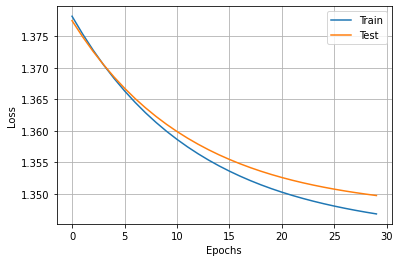

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.gca()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [19]:
y_pred_color = model.predict(X_test_gray)
y_pred_color = y_pred_color.reshape(X_test_gray.shape[0] * 32 * 32, 4)
output_images = []
for index in range(len(y_pred_color)):
    output_images.append([int(color) for color in main_colors[np.argmax(y_pred_color[index])]])
    
y_test_reshaped = y_test_gray.reshape(X_test_gray.shape[0] * 32 * 32, 4)
y_test_k_color = []
for p in range(len(y_test_reshaped)):
    y_test_k_color.append([int(color) for color in main_colors[np.argmax(y_test_reshaped[p])]])
output_images = np.reshape(output_images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))

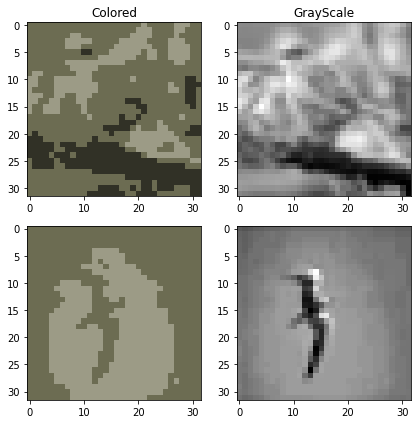

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(y_test_k_color[233])
ax[1].imshow(X_test_gray.reshape(-1,32,32)[233], cmap=plt.cm.gray)

ax[2].imshow(y_test_k_color[66])
ax[3].imshow(X_test_gray.reshape(-1,32,32)[66], cmap=plt.cm.gray)

ax[0].set_title("Colored")
ax[1].set_title("GrayScale")

fig.tight_layout()
plt.show()